# Proyecto #1: Notebook Email Phishing

### Estudiantes
    John Sánchez Cespedes 3021080092
    Luis Carlos Navarro Todd 2022212158
    Victoria Sandí Barrantes 2022146536

### Imports

In [220]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, Normalizer, QuantileTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.datasets import load_iris

# 1. Análisis Exploratorio de Datos (EDA) y Preprocessing

In [221]:
ds = pd.read_csv("./email_phishing.csv")
ds.head()

,num_words,num_unique_words,num_stopwords,num_links,num_unique_domains,num_email_addresses,num_spelling_errors,num_urgent_keywords,label
0,140,94,52,0,0,0,0,0,0
1,5,5,1,0,0,0,0,0,0
2,34,32,15,0,0,0,0,0,0
3,6,6,2,0,0,0,0,0,0
4,9,9,2,0,0,0,0,0,0


## Exploración Estadística de los datos
Antes de hacer cualquier exploración y seguir trabajando con un dataset es importante que el dataset en general tenga datos con cierto sentido, por lo tanto observar la media, los mínimos, los máximos y los cuartiles puede generar una idea inicial.

In [222]:
ds.describe().T

,count,mean,std,min,25%,50%,75%,max
num_words,524846.0,276.228000,3335.456750,0.0,47.0,120.0,269.0,2339682.0
num_unique_words,524846.0,123.012167,201.626478,0.0,38.0,79.0,145.0,51251.0
num_stopwords,524846.0,80.045465,1023.330380,0.0,12.0,34.0,79.0,720411.0
num_links,524846.0,0.895588,5.603001,0.0,0.0,0.0,0.0,824.0
num_unique_domains,524846.0,0.347767,1.774209,0.0,0.0,0.0,0.0,524.0
num_email_addresses,524846.0,2.114897,13.592682,0.0,0.0,0.0,1.0,1150.0
num_spelling_errors,524846.0,24.694731,311.312358,0.0,2.0,8.0,22.0,190104.0
num_urgent_keywords,524846.0,0.245301,0.559320,0.0,0.0,0.0,0.0,7.0
label,524846.0,0.013240,0.114301,0.0,0.0,0.0,0.0,1.0


El dataset muestra outliers extremos, como documentos con 2.3M palabras (considerando que la media es de 276) o 190K errores ortográficos (media de 25). Más del 50% de los registros tienen 0 enlaces, 0 dominios únicos o 0 emails, lo que podría indicar datos incompletos. Además, las grandes diferencias entre medias y medianas confirman distribuciones muy sesgadas por valores anómalos.

## Ver balance de los datos

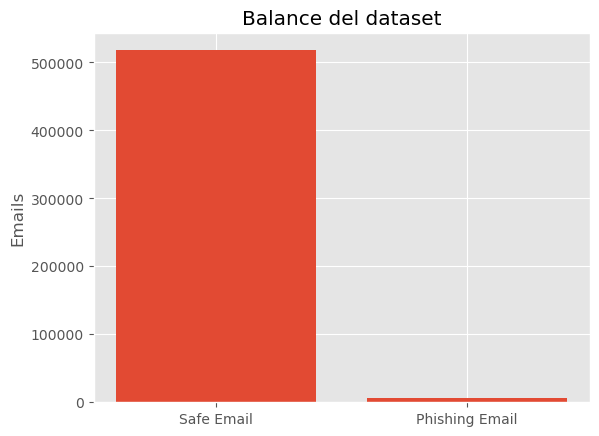

In [223]:
fig, ax = plt.subplots()

ax.bar(["Safe Email", "Phishing Email"], ds.value_counts("label"))

ax.set_ylabel("Emails")
ax.set_title("Balance del dataset")

plt.show()

Como se puede observar un muy bajo porcentaje es de phishing emails, solo el 1.3% de las muestras son positivas (label=1), demostrando un gran desbalance

## Valores faltantes
Para tratar los valores inválidos (como ceros en columnas donde no son válidos) y los valores faltantes, se implementará la siguiente estrategia:

**Marcar Valores Inválidos como Nulos:**

Columnas como num_words y num_unique_words no deberían tener valores en 0 (a menos que el correo esté vacío, lo cual es inusual), por lo que se reemplazarán con NaN

In [224]:
ds[['num_words', 'num_unique_words']] = ds[['num_words', 'num_unique_words']].replace(0, np.nan)

**Calcular Medianas por Clase (phishing=1 vs safe=0):**

Calculamos las medianas de cada variable según la clase del email para imputar los valores faltantes de manera diferenciada

In [225]:
def median_target(var):   
    temp = ds[ds[var].notnull()]
    temp = temp[[var, 'label']].groupby(['label'])[[var]].median().reset_index()
    return temp

#### num_words

In [226]:
median_target('num_words')

,label,num_words
0,0,120.0
1,1,110.0


Se utilizará 120 para los safe emails y 110 para los phishing emails.

In [227]:
ds.loc[(ds['label'] == 0 ) & (ds['num_words'].isnull()), 'num_words'] = 120.0
ds.loc[(ds['label'] == 1 ) & (ds['num_words'].isnull()), 'num_words'] = 110.0

#### num_unique_words

In [228]:
median_target('num_unique_words')

,label,num_unique_words
0,0,78.0
1,1,81.0


Se utilizará 78 para los safe emails y 81 para los phishing emails.

In [229]:
ds.loc[(ds['label'] == 0 ) & (ds['num_unique_words'].isnull()), 'num_unique_words'] = 78.0
ds.loc[(ds['label'] == 1 ) & (ds['num_unique_words'].isnull()), 'num_unique_words'] = 81.0

#### Después de limpieza de nulos

In [230]:
ds.isna().sum()

num_words              0
num_unique_words       0
num_stopwords          0
num_links              0
num_unique_domains     0
num_email_addresses    0
num_spelling_errors    0
num_urgent_keywords    0
label                  0
dtype: int64

In [231]:
ds.describe().T

,count,mean,std,min,25%,50%,75%,max
num_words,524846.0,276.229829,3335.456632,1.0,47.0,120.0,269.0,2339682.0
num_unique_words,524846.0,123.013356,201.625982,1.0,38.0,79.0,145.0,51251.0
num_stopwords,524846.0,80.045465,1023.330380,0.0,12.0,34.0,79.0,720411.0
num_links,524846.0,0.895588,5.603001,0.0,0.0,0.0,0.0,824.0
num_unique_domains,524846.0,0.347767,1.774209,0.0,0.0,0.0,0.0,524.0
num_email_addresses,524846.0,2.114897,13.592682,0.0,0.0,0.0,1.0,1150.0
num_spelling_errors,524846.0,24.694731,311.312358,0.0,2.0,8.0,22.0,190104.0
num_urgent_keywords,524846.0,0.245301,0.559320,0.0,0.0,0.0,0.0,7.0
label,524846.0,0.013240,0.114301,0.0,0.0,0.0,0.0,1.0


## Outliers restantes
Hace falta tratar los outliers restantes, por lo tanto se visualizarán con un boxplot por feature.

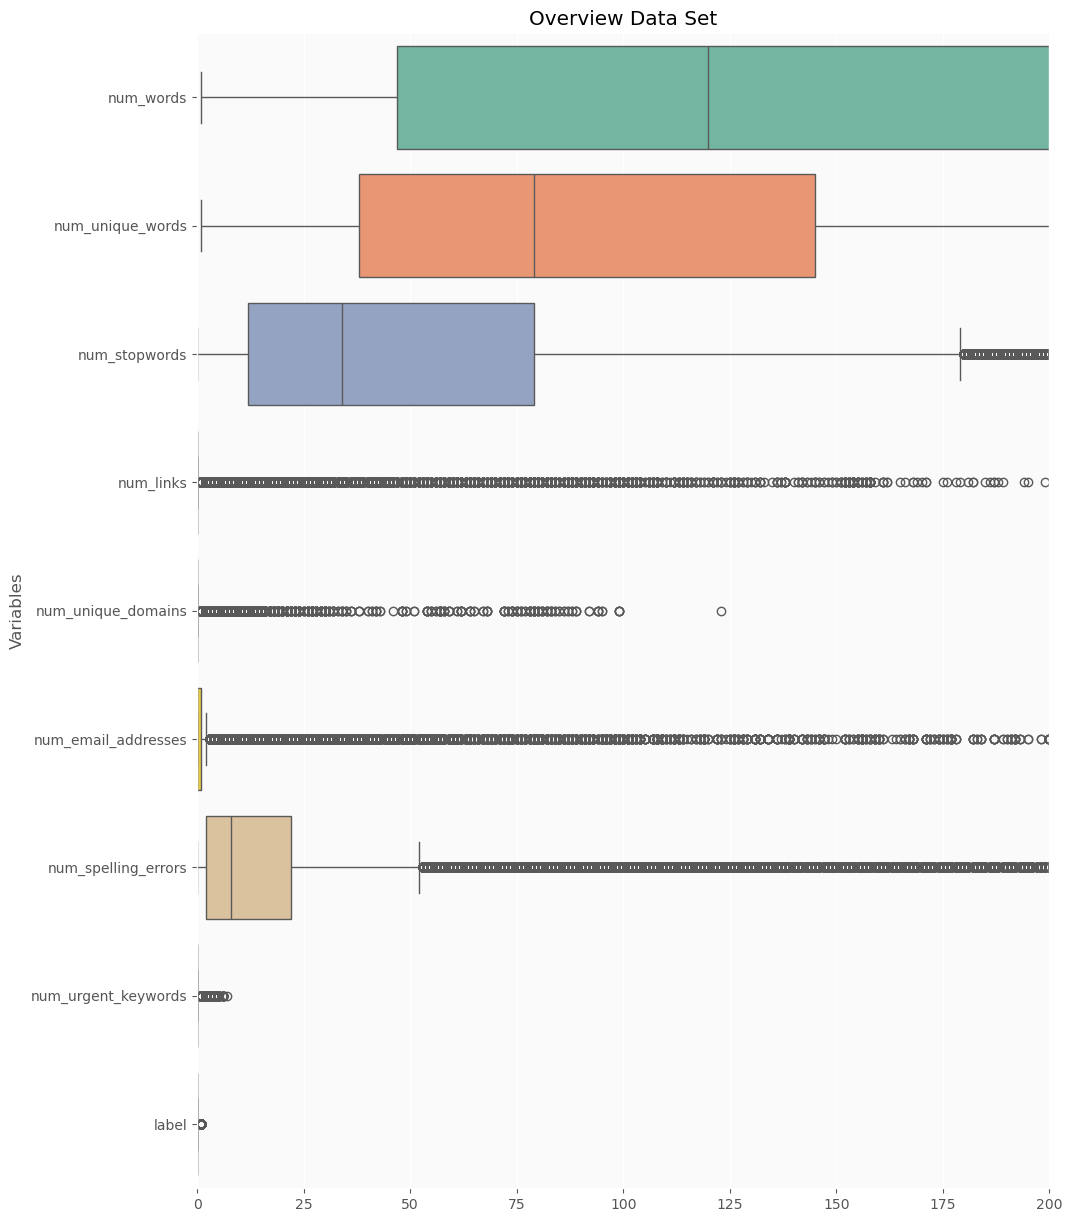

In [232]:
plt.style.use('ggplot') # Using ggplot2 style visuals 

f, ax = plt.subplots(figsize=(11, 15))

ax.set_facecolor('#fafafa')
ax.set(xlim=(-.05, 200))
plt.ylabel('Variables')
plt.title("Overview Data Set")
ax = sns.boxplot(ds, 
  orient = 'h', 
  palette = 'Set2')



Para tratar los outliers se utilizará la técnica de IQR.

In [233]:
def handle_phishing_outliers(df):
    # Crear copia del dataframe
    df_clean = df.copy()
    
    # 1. Columnas donde SÍ capamos outliers (errores)
    cols_to_cap = [
        'num_words',           # Valores extremos son likely errores
        'num_stopwords',       # Ej: 0 o >10,000 stopwords
        'num_spelling_errors'  # Ej: >100 errores es likely ruido
    ]
    
    # 2. Columnas donde NO intervenimos (outliers pueden ser phishing)
    cols_no_touch = [
        'num_links',            # Muchos enlaces = señal de phishing
        'num_unique_domains',   # Múltiples dominios = sospechoso
        'num_email_addresses',  # Muchos emails podría ser ataque
        'num_urgent_keywords',  # Palabras urgentes son clave
        'label'                 # No tocar la variable objetivo
    ]
    
    # 3. Calcular y aplicar límites solo a cols_to_cap
    Q1 = df_clean[cols_to_cap].quantile(0.25)
    Q3 = df_clean[cols_to_cap].quantile(0.75)
    IQR = Q3 - Q1
    
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    
    # Capar valores fuera de los límites
    df_clean[cols_to_cap] = df_clean[cols_to_cap].clip(
        lower=lower_bound,
        upper=upper_bound,
        axis=1
    )
    
    return df_clean

In [234]:
ds = handle_phishing_outliers(ds)
ds.describe().T

,count,mean,std,min,25%,50%,75%,max
num_words,524846.0,188.606334,182.956599,1.0,47.0,120.0,269.0,602.0
num_unique_words,524846.0,123.013356,201.625982,1.0,38.0,79.0,145.0,51251.0
num_stopwords,524846.0,54.940383,55.156752,0.0,12.0,34.0,79.0,179.5
num_links,524846.0,0.895588,5.603001,0.0,0.0,0.0,0.0,824.0
num_unique_domains,524846.0,0.347767,1.774209,0.0,0.0,0.0,0.0,524.0
num_email_addresses,524846.0,2.114897,13.592682,0.0,0.0,0.0,1.0,1150.0
num_spelling_errors,524846.0,15.242913,16.769821,0.0,2.0,8.0,22.0,52.0
num_urgent_keywords,524846.0,0.245301,0.559320,0.0,0.0,0.0,0.0,7.0
label,524846.0,0.013240,0.114301,0.0,0.0,0.0,0.0,1.0


## Selección de features
Para seleccionar los features que se utilizarán en el modelo hay que visualizar la correlación entre las diferentes variables independientes y la variable dependiente para ver si tienen un peso significativo para tomarlas en cuenta o están generando ruido.

<Axes: >

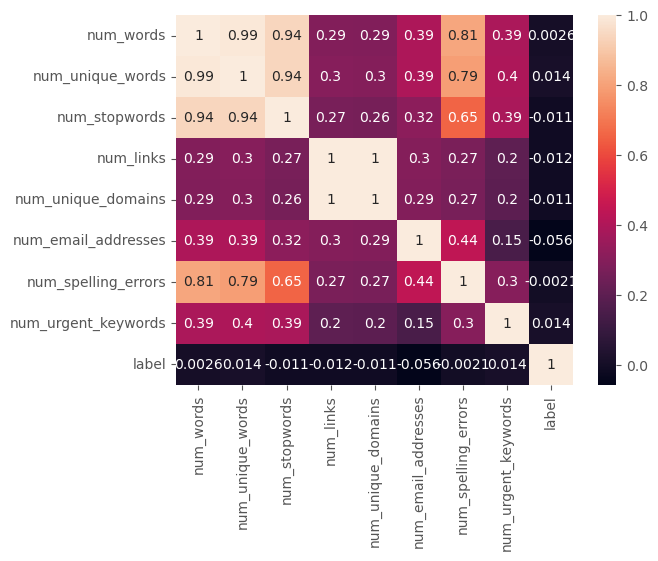

In [235]:
sns.heatmap(ds.corr('spearman'),annot=True)

Como se puede observar, todas las variables muestran correlaciones muy bajas con el target (entre -0.056 y +0.014), entonces se propone una selección por dominio (MD), conservando las variables más relevantes para phishing (num_links, num_email_addresses y num_urgent_keywords) a pesar de su baja correlación, ya que capturan patrones típicos de ataques (URLs maliciosas, remitentes falsos y lenguaje urgente)

In [236]:
X = ds.drop(["label"], axis=1)
X_MD = ds.drop(["num_words", "num_unique_words", "num_stopwords", "num_unique_domains", "num_spelling_errors", "label"], axis=1)
y = ds["label"]

### Estandarización

In [237]:
sc = StandardScaler()
X = sc.fit_transform(X)
X_MD = sc.fit_transform(X_MD)

### Normalización

In [238]:
normalizer = Normalizer()
X = normalizer.fit_transform(X)
X_MD = normalizer.fit_transform(X_MD)

### División de los datos

In [239]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0, shuffle=True)
X_MD_train, X_MD_test, y_MD_train, y_MD_test = train_test_split(X_MD, y, test_size=0.2, random_state=0, shuffle=True)

## Modelo Scikit learn

Inicializar el modelo de regresión logística de Scikit learn

In [240]:
lgModel = LogisticRegression(random_state=42)
lgModel_MD = LogisticRegression(random_state=42)

Ajustar el modelo al conjunto de entrenamiento

In [241]:
lgModel.fit(X_train, y_train)
lgModel_MD.fit(X_MD_train, y_MD_train)

LogisticRegression(random_state=42)

Predecir en el conjunto de prueba

In [242]:
y_pred = lgModel.predict(X_test)
y_MD_pred = lgModel_MD.predict(X_MD_test)

#### Evaluar el rendimiento de los modelos

In [243]:
accuracy = accuracy_score(y_test, y_pred)
accuracy_MD = accuracy_score(y_MD_test, y_MD_pred)

print(f'Accuracy del modelo con todos los features: {accuracy}')
print(f'Accuracy del modelo con los features seleccionados por dominio: {accuracy_MD}')

Accuracy del modelo con todos los features: 0.9867676478993999
Accuracy del modelo con los features seleccionados por dominio: 0.9867676478993999


#### Informe de clasificación

Todos los features:

              precision    recall  f1-score   support

           0       0.99      1.00      0.99    103581
           1       0.00      0.00      0.00      1389

    accuracy                           0.99    104970
   macro avg       0.49      0.50      0.50    104970
weighted avg       0.97      0.99      0.98    104970



c:\Users\vicky\anaconda3\envs\environment.yml\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\vicky\anaconda3\envs\environment.yml\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\vicky\anaconda3\envs\environment.yml\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitaliz

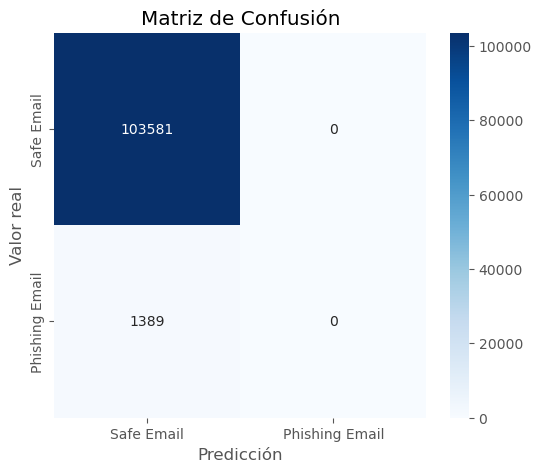

In [244]:
informe_clasificacion = classification_report(y_test, y_pred)
print(informe_clasificacion)

# Evaluacion del desempenno
cm = confusion_matrix(y_test, y_pred)
# Mostrar la matriz de confusion
# Etiquetas de las clases
labels = ['Safe Email', 'Phishing Email']

# Crear un heatmap
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=labels, yticklabels=labels)

plt.xlabel('Predicción')
plt.ylabel('Valor real')
plt.title('Matriz de Confusión')
plt.show()

Features seleccionados por dominio:

c:\Users\vicky\anaconda3\envs\environment.yml\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\vicky\anaconda3\envs\environment.yml\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\vicky\anaconda3\envs\environment.yml\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitaliz

                 precision    recall  f1-score   support

    Safe Emails       0.99      1.00      0.99    103581
Phishing Emails       0.00      0.00      0.00      1389

       accuracy                           0.99    104970
      macro avg       0.49      0.50      0.50    104970
   weighted avg       0.97      0.99      0.98    104970



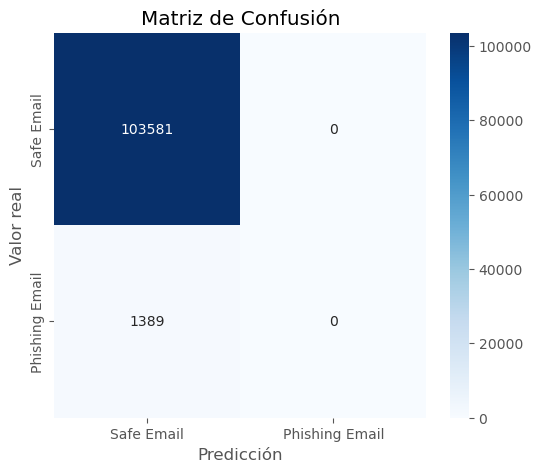

In [245]:
informe_clasificacion_MD = classification_report(y_MD_test, y_MD_pred, target_names=["Safe Emails", "Phishing Emails"])
print(informe_clasificacion_MD)

cm = confusion_matrix(y_MD_test, y_MD_pred)

# Crear un heatmap
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=labels, yticklabels=labels)

plt.xlabel('Predicción')
plt.ylabel('Valor real')
plt.title('Matriz de Confusión')
plt.show()

## Modelo KNN Scikit Learn

### ¿Cuál es el mejor K?

In [246]:
# Función para calcular errores para un set de features
def calcular_errores(X_train, y_train, X_test, y_test):

    errores = []
    for k in range(1, 21):
        modelo = KNeighborsClassifier(n_neighbors=k)
        modelo.fit(X_train, y_train)
        pred = modelo.predict(X_test)
        errores.append(1 - accuracy_score(y_test, pred))
    return errores

In [ ]:
# Calcular errores para los dos modelos
errores1 = calcular_errores(X_train, y_train, X_test, y_test)
errores2 = calcular_errores(X_MD_train, y_MD_train, X_MD_test, y_MD_test)
# Graficar los tres conjuntos de errores
k_range = range(1, 21)
plt.plot(k_range, errores1, label='Todas las features', marker='o')
plt.plot(k_range, errores2, label='Features seleccionados por dominio', marker='s')

plt.title("Tasa de error vs K (comparación de modelos)")
plt.xlabel("Valor de K")
plt.ylabel("Tasa de error")
plt.legend()
plt.grid(True)
plt.show()

#### Debido al análisis anterior, se observa que el valor de K que produce la menor tasa de error es K = 2. Sin embargo, este valor puede no ser el más recomendable en un escenario práctico, ya que usar un valor tan bajo de K puede hacer al modelo más sensible al ruido en los datos. Alternativamente, se puede considerar utilizar un valor de K = 4, que aunque presenta una tasa de error ligeramente superior, ofrece una mayor estabilidad en la clasificación y reduce el riesgo de sobreajuste. Además, valores de K moderados permiten un balance entre precisión y eficiencia computacional, especialmente en conjuntos de datos más grandes

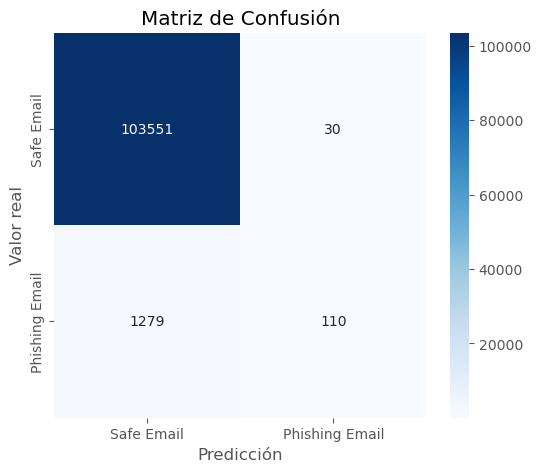


Reporte de clasificación:
               precision    recall  f1-score   support

         0.0       0.99      1.00      0.99    103581
         1.0       0.79      0.08      0.14      1389

    accuracy                           0.99    104970
   macro avg       0.89      0.54      0.57    104970
weighted avg       0.99      0.99      0.98    104970

Precisión (accuracy): 0.9875297704105935


In [ ]:

knn = KNeighborsClassifier(n_neighbors=4)  # Puedes ajustar este valor
knn.fit(X_train, y_train)

# Hacer pruebas al modelo
y_knn_pred = knn.predict(X_test)

# Evaluacion del desempenno
cm = confusion_matrix(y_test, y_knn_pred)
# Mostrar la matriz de confusion
# Etiquetas de las clases
labels = ['Safe Email', 'Phishing Email']

# Crear un heatmap
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=labels, yticklabels=labels)

plt.xlabel('Predicción')
plt.ylabel('Valor real')
plt.title('Matriz de Confusión')
plt.show()


print("\nReporte de clasificación:\n", classification_report(y_test, y_knn_pred))
print("Precisión (accuracy):", accuracy_score(y_test, y_knn_pred))

### Despues de un analisis se tiene lo siguiente:


### Conclusiones
